In [1]:
import tensorflow as tf
import cv2 as cv
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import tensorboard as tb
import matplotlib.pyplot as plt
import imageio
import re
import seedir as sd
import datetime
from functools import partial

print('tf: '+tf.__version__)
print('cv: '+cv.__version__)

tf: 2.9.1
cv: 4.0.1


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


FUNCTIONS TO MANIPULATE AND PLAY VIDEOS

In [3]:
#Function that plays the videos within a directory
def play_videos(directory):
    
    for video_name in os.listdir(directory):
    # try:
            cap=cv.VideoCapture(directory+video_name)
            while cap.isOpened():
                ret, frame=cap.read()
                if not ret:
                    print("Can't receive frame (stream end?). Exiting...")
                    break
                cv.imshow('frame',frame)
                if cv.waitKey(1)==ord('q'):
                    break

            cap.release()
            cv.destroyAllWindows()
#play_videos('../hmdb51_org/fall_floor/')

Define hyperparameters

In [5]:
epochs=100
frame_size=240
batch_size=32
frames_per_video=10
frame_separation=0

In [3]:
#Function that crops the frames
def crop_center_square(frame):
  y, x = frame.shape[0:2]
  min_dim = min(y, x)
  start_x = (x // 2) - (min_dim // 2)
  start_y = (y // 2) - (min_dim // 2)
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim]

#Function that loads video
def load_video(path, max_frames=0, frame_separation=0, resize=(frame_size, frame_size)):
  cap = cv.VideoCapture(path)
  frames = []
  length = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
  if length<37: #((frame_separation+1)*max_frames)
    frame_separation=0
  frame_count=0

  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      if frame_separation<=0 or (frame_count % (frame_separation+1))==0:
        frame = crop_center_square(frame)
        frame = cv.resize(frame, resize)
        frame = frame[:, :, [2, 1, 0]]
        frames.append(frame)
        

        if len(frames) == max_frames:
          break
      frame_count+=1
  finally:
    cap.release()
  return np.array(frames)

#Makes a gif out of frames
def to_gif(images,name):
  converted_images = np.clip(images, 0, 255).astype(np.uint8)
  imageio.mimsave(name, converted_images, fps=30)

#sample_video = load_video('../hmdb51_org/fall_floor/THE_PROTECTOR_fall_floor_f_nm_np1_le_bad_2.avi',10,3)
# to_gif(sample_video, 'sin_recorte.gif')
# sample_video = load_video('../hmdb51_org/fall_floor/Catch_Me_If_You_Can_fall_floor_f_cm_np1_fr_med_0.avi',10,3)
# to_gif(sample_video, 'con_recorte.gif')

We get the labels of the HMDB51 dataset

In [4]:
labels = os.listdir('../hmdb51_org')
adl_labels={
    "brush_hair":labels.index("brush_hair"),
    "climb_stairs":labels.index("climb_stairs"),
    "drink":labels.index("drink"),
    "eat":labels.index("eat"),
    "fall_floor":labels.index("fall_floor"),
    "pick":labels.index("pick"),
    "push":labels.index("push"),
    "run":labels.index("run"),
    "sit":labels.index("sit"),
    "stand":labels.index("stand"),
    "walk":labels.index("walk")
}

Function for getting the name and lable of the different train and test split videos.

In [68]:
def get_split(split_number,labels=None):
    splits_files= os.listdir('../test_train_splits')
    train_split=[]
    test_split=[]
    r = re.compile(str(split_number)+'\.txt$')
    split_files=list(filter(r.search,splits_files))

    for file in split_files:
        file_class=file.rsplit("_test")[0]
        if labels is None or file_class in labels:

            f=open('../test_train_splits/'+file,'r')
            for line in f:
                if(re.search('1 $',line)):
                    train_split.append((line.split(' ',1)[0],file.split('_test',1)[0]))
                elif(re.search('2 $',line)):
                    test_split.append((line.split(' ',1)[0],file.split('_test',1)[0]))

            f.close()
    return (train_split,test_split)
train_split1,test_split1=get_split(1)
train_split1_adl,test_split1_adl=get_split(1,labels=adl_labels)
train_split2_adl,test_split2_adl=get_split(2,labels=adl_labels)
train_split3_adl,test_split3_adl=get_split(3,labels=adl_labels)
train_filenames_binary=train_split1_adl
test_filenames_binary=test_split1_adl

for name,label in train_split2_adl:
    if label == "fall_floor":
        train_filenames_binary.append((name,label))

for name,label in test_split2_adl:
    if label == "fall_floor":
        test_filenames_binary.append((name,label))

for name,label in train_split3_adl:
    if label == "fall_floor":
        train_filenames_binary.append((name,label))

for name,label in test_split3_adl:
    if label == "fall_floor":
        test_filenames_binary.append((name,label))

print()


Functions that converts numpys to TFRecords

In [6]:

def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def save_numpy_to_tfrecords(data, label, destination_path, name, fragmentSize,
                            current_batch_number, total_batch_number,
                            color_depth):
  """Converts an entire dataset into x tfrecords where x=videos/fragmentSize.

  Args:
    data: ndarray(uint32) of shape (v,i,h,w,c) with v=number of videos,
    i=number of images, c=number of image channels, h=image height, w=image
    width
    name: filename; data samples type (train|valid|test)
    fragmentSize: specifies how many videos are stored in one tfrecords file
    current_batch_number: indicates the current batch index (function call within loop)
    total_batch_number: indicates the total number of batches
  """

  num_videos = data.shape[0]
  num_images = data.shape[1]
  num_channels = data.shape[4]
  height = data.shape[2]
  width = data.shape[3]

  writer = None
  feature = {}

  for video_count in range((num_videos)):

    if video_count % fragmentSize == 0:
      if writer is not None:
        writer.close()
      filename = os.path.join(destination_path,
                              name + str(current_batch_number) + '_of_' + str(
                                total_batch_number) + '.tfrecord')
      print('Writing', filename)
      writer = tf.io.TFRecordWriter(filename)

    for image_count in range(num_images):
      path = 'blob' + '/' + str(image_count)
      image = data[video_count, image_count, :, :, :]
      image = image.astype(color_depth)
      image_raw = image.tobytes()

      feature[path] = _bytes_feature(image_raw)
      
    feature['label'] = _int64_feature(label)
    
    example = tf.train.Example(features=tf.train.Features(feature=feature))
    writer.write(example.SerializeToString())
  if writer is not None:
    writer.close()

In [7]:
def _float_feature(value):
  return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def save_feature_to_tfrecord(video_features,labels,destination_path,name):
  num_videos = video_features.shape[0]
  num_images = video_features.shape[1]
  num_features = video_features.shape[2]

  filename = os.path.join(destination_path, name + '.tfrecord')
  writer = tf.io.TFRecordWriter(filename)
  print('Writing', filename)
  feature = {}

  for video_count in range(num_videos):
    for image_count in range(num_images):
      path="feature/"+str(image_count)
      frame_feature=video_features[video_count,image_count,:]

      feature[path] = _float_feature(frame_feature)

    feature['label'] = _int64_feature(labels[video_count])

    example = tf.train.Example(features=tf.train.Features(feature=feature))
    writer.write(example.SerializeToString())
    
   
    

Function that converts the videos from a split into TFRecords

In [8]:

def split_to_tfrecords(split_data,split_number,split_type,n_videos_in_record):
    
    n_of_records=int(len(split_data)/n_videos_in_record)
    hmdb51_directory='../hmdb51_org/'

    i=0
    for batch in range(n_of_records):

        data=[]
        current_batch=split_data[i:i+n_videos_in_record]
        label_of_batch=current_batch[0][1]
    
        for name_and_label in current_batch:
            np_video=load_video(hmdb51_directory+name_and_label[1]+'/'+name_and_label[0],frames_per_video,frame_separation)
            data.append(np_video)
        
        path='../tfRecords/split'+str(split_number)+'/'+label_of_batch
        if not os.path.exists(path):
            os.makedirs(path)
        save_numpy_to_tfrecords(np.array(data), batch, path, split_type+'Batch_', n_videos_in_record,batch+1, total_batch_number=n_of_records, color_depth="uint8")
        i=i+n_videos_in_record

#split_to_tfrecords(train_split1,1,'train',70)
#split_to_tfrecords(test_split1,1,'test',30)
#split_to_tfrecords(train_split1_adl,1,'adl_train',70)
#split_to_tfrecords(test_split1_adl,1,'adl_test',30)
# split_to_tfrecords(train_split2_adl,2,'adl_train',70)
# split_to_tfrecords(test_split2_adl,2,'adl_test',30)
# split_to_tfrecords(train_split3_adl,3,'adl_train',70)
# split_to_tfrecords(test_split3_adl,3,'adl_test',30)

Function to load a video from a serialized example of a TFRecordDataset

In [9]:

def load_video_from_tfrecord(binary,serialized_example):
    
    video = []
    for image_count in range(frames_per_video):
        path = 'blob' + '/' + str(image_count)
        feature_dict = {
            path: tf.io.FixedLenFeature([], tf.string),
            'label':tf.io.FixedLenFeature([],tf.int64)
        }
        
        features = tf.io.parse_example(serialized_example,features=feature_dict)

        frame_raw = features[path]
        label=features['label']
        if binary:
            if label == 4:
                label=1
            else:
                label=0
    
        frame = tf.io.decode_raw(frame_raw,out_type=tf.uint8)
        frame = tf.reshape(frame, shape=[frame_size, frame_size, 3])

        video.append(frame)
    return (video,label)

def load_features_from_tfrecord(serialized_example):

    video_features = []
    for image_count in range(frames_per_video):
        path = 'feature' + '/' + str(image_count)
        feature_dict = {
            path: tf.io.FixedLenFeature([2048], tf.float32),
            'label':tf.io.FixedLenFeature([],tf.int64)
        }

        features = tf.io.parse_example(serialized_example,features=feature_dict)
        
        video_features.append(features[path])
        label=features['label']
    return (video_features,label)

# filename=['../tfRecords/split1/drink/adl_trainBatch_3_of_11.tfrecord']

# raw_tfrecord=tf.data.TFRecordDataset(filename)

# x=raw_tfrecord.take(1)
# video=load_video_from_tfrecord(next(iter(x)))
# print()
# to_gif(video[0])


Function to load dataset

In [10]:
def load_dataset(filenames,binary=False):
    ignore_order = tf.data.Options()
    ignore_order.deterministic = False
    dataset=tf.data.TFRecordDataset(filenames)
    dataset=dataset.with_options(ignore_order)
    if binary:
        dataset=dataset.map(partial(load_video_from_tfrecord,binary))
    else: dataset=dataset.map(partial(load_video_from_tfrecord,binary))
    return dataset

def load_features(filenames):
    ignore_order = tf.data.Options()
    ignore_order.deterministic = False
    dataset=tf.data.TFRecordDataset(filenames)
    dataset=dataset.with_options(ignore_order)
    dataset=dataset.map(partial(load_features_from_tfrecord))
    return dataset

def get_dataset(filenames,batch_size=0,binary=False):
    dataset = load_dataset(filenames,binary)
    if batch_size>0:
        dataset = dataset.batch(batch_size)
    return dataset

def get_features(filenames,batch_size=0):
    dataset = load_features(filenames)
    dataset = dataset.shuffle(3570)
    if batch_size>0:
        dataset = dataset.batch(batch_size)
        
    return dataset


In [28]:
train_filenames = tf.io.gfile.glob('../tfRecords/split1/*/train*.tfrecord')
test_filenames = tf.io.gfile.glob('../tfRecords/split1/*/test*.tfrecord')
train_filenames_adl = tf.io.gfile.glob('../tfRecords/split*/*/adl_train*.tfrecord')
test_filenames_adl = tf.io.gfile.glob('../tfRecords/split*/*/adl_test*.tfrecord')

train_filenames_fall = tf.io.gfile.glob('../tfRecords/split*/fall_floor/adl_train*.tfrecord')
test_filenames_fall = tf.io.gfile.glob('../tfRecords/split*/fall_floor/adl_test*.tfrecord')

train_filenames_not_fall = tf.io.gfile.glob('../tfRecords/split1/*/adl_train*.tfrecord')
test_filenames_not_fall = tf.io.gfile.glob('../tfRecords/split1/*/adl_test*.tfrecord')

for i in range(len(train_filenames_not_fall)):
    if train_filenames_not_fall[i].find("fall_floor")>-1:
        train_filenames_not_fall.pop(i)
        break

for i in range(len(test_filenames_not_fall)):
    if test_filenames_not_fall[i].find("fall_floor")>-1:
        test_filenames_not_fall.pop(i)
        break

train_dataset = get_dataset(train_filenames)
test_dataset = get_dataset(test_filenames)

train_dataset_adl = get_dataset(train_filenames_adl)
test_dataset_adl = get_dataset(test_filenames_adl)

train_dataset_fall = get_dataset(train_filenames_fall,binary=True)

test_dataset_fall = get_dataset(test_filenames_fall,binary=True)
train_dataset_not_fall = get_dataset(train_filenames_not_fall,binary=True)
test_dataset_not_fall = get_dataset(test_filenames_not_fall,binary=True)

train_dataset_binary = train_dataset_fall.concatenate(train_dataset_not_fall)
train_dataset_binary = train_dataset_binary.shuffle(910)
test_dataset_binary = test_dataset_fall.concatenate(test_dataset_not_fall)
test_dataset_binary = test_dataset_binary.shuffle(390)

# print(train_dataset)
# x=train_dataset_fall.take(5)
# it=iter(x)
# aux=next(it)
# video_and_label=next(it)
# video=video_and_label[0][0]
# label=video_and_label[1]
# to_gif(video)

Checkpoints

In [36]:
initial_learning_rate = 0.00001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=20, decay_rate=0.96, staircase=True
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "../checkpoint/binary_activity_LSTMmodel_{epoch:02d}-{val_loss:.2f}.hdf5", save_best_only=True,
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=5, restore_best_weights=True, 
)

In [15]:
#model.fit(train_dataset, epochs=10, callbacks=[checkpoint_cb,early_stopping_cb])

In [16]:
sd.seedir('../tfRecords', style='emoji', itemlimit=3, beyond='content')

📁 tfRecords/
├─📁 split1/
│ ├─📁 brush_hair/
│ │ ├─📄 testBatch_1_of_51.tfrecord
│ │ └─📄 trainBatch_1_of_51.tfrecord
│ ├─📁 cartwheel/
│ │ ├─📄 testBatch_2_of_51.tfrecord
│ │ └─📄 trainBatch_2_of_51.tfrecord
│ ├─📁 catch/
│ │ ├─📄 testBatch_3_of_51.tfrecord
│ │ └─📄 trainBatch_3_of_51.tfrecord
│ └─📄 48 folder(s), 0 file(s)
├─📁 split2/
└─📁 split3/


CNN+RNN

We define the convolutional base that we are going to use for feature extraction.

In [13]:
def new_feature_extractor():
    feature_extractor = tf.keras.applications.Xception(
        weights='imagenet',
        pooling='avg',
        include_top=False,
        input_shape=(frame_size,frame_size,3)
    )
    inputs = tf.keras.Input((frame_size,frame_size,3))
    preprocess = tf.keras.applications.xception.preprocess_input

    preprocessed = preprocess(inputs)

    out = feature_extractor(preprocessed)
    return tf.keras.Model(inputs,out, name="extractor_carecteristicas")
feature_extractor = new_feature_extractor()

In [31]:
def extract_features(dataset,num_videos):
        
    print(num_videos)
    frame_features = np.zeros(
        shape=(num_videos, frames_per_video, 2048), dtype="float32"
    )
    labels=np.zeros(shape=(num_videos,),dtype="int8")
    for index, video_label in enumerate(dataset):
        #print(video_label)

        frames = video_label[0]
        label = video_label[1]
        labels[index]=label.numpy()

        frames=frames[None, ...]
        aux_features = np.zeros(
            shape=(1, frames_per_video, 2048), dtype='float32'
        )

        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            for j in range(video_length):
                aux_features[i, j, :] = feature_extractor.predict(batch[None,j,:], verbose=0)

        
        frame_features[index,] = aux_features.squeeze()
        print(index)
    return frame_features,labels

# trn_features=extract_features(train_dataset,len(train_split1))
# tst_features=extract_features(test_dataset,len(test_split1))
# trn_features=extract_features(train_dataset_adl,len(train_split1_adl)*3)
# tst_features=extract_features(test_dataset_adl,len(test_split1_adl)*3)
trn_features=extract_features(train_dataset_binary,70*10+70*3)
tst_features=extract_features(test_dataset_binary,30*10+30*3)
save_feature_to_tfrecord(trn_features[0],trn_features[1],'../features','binary_trainavg')
save_feature_to_tfrecord(tst_features[0],tst_features[1],'../features','binary_testavg')
#print(features)

910
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

In [38]:

train_features=get_features('../features/binary_trainavg.tfrecord',batch_size)

test_features=get_features('../features/binary_testavg.tfrecord',batch_size)
# j=1
# for i,feature_label in enumerate(train_features):
#     if feature_label[1].numpy()[0]==0:
#         print(j)
#         j+=1
#sum(1 for _ in test_dataset)


In [11]:
def new_lstm_model(n_labels):
    frame_features_input = tf.keras.Input((frames_per_video, 2048),name="input")

    x = tf.keras.layers.LSTM(4096, return_sequences=False,dropout=0.5, name="lstm")(frame_features_input)
    #x = tf.keras.layers.lstm(1024)(x)
    x = tf.keras.layers.Dense(512, activation='relu', name="dense_relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(n_labels, activation='softmax',name="dense_classification")(x)

    lstm_model = tf.keras.Model(frame_features_input,output)

    lstm_model.compile(
        loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
    )
    return lstm_model

def new_binary_lstm_model():
    frame_features_input = tf.keras.Input((frames_per_video, 2048))

    x = tf.keras.layers.LSTM(4096, return_sequences=False,dropout=0.5)(frame_features_input)
    #x = tf.keras.layers.lstm(1024)(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    lstm_model = tf.keras.Model(frame_features_input,output)

    lstm_model.compile(
        loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy',tf.keras.metrics.AUC()]
    )
    return lstm_model

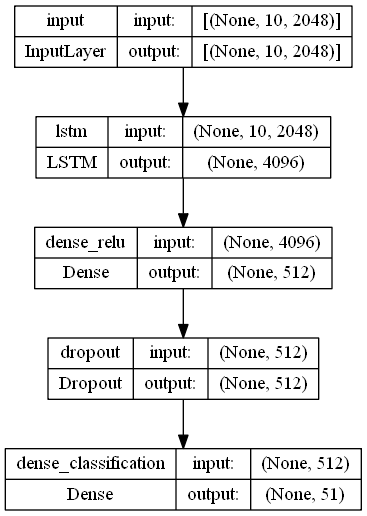

In [16]:
#lstm_model = new_lstm_model(51)
tf.keras.utils.plot_model(lstm_model, "lstm_modelo_tfg.png", show_shapes=True)

Training of RNN

In [42]:
def run_lstm_experiment(train_data, test_data, n_labels):

    
    log_dir = "../logs/lstm_"+str(n_labels)+"/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

    history = lstm_model.fit(
        train_data,
        validation_data=test_data,
        epochs=100,
        callbacks=[checkpoint_cb,early_stopping_cb,tensorboard_cb],
    )
    return history

history_lstm=run_lstm_experiment(train_features,test_features,2)

Epoch 1/100
29/29 [==============================] - 23s 661ms/step - loss: 0.7845 - binary_accuracy: 0.7275 - auc: 0.4928 - val_loss: 0.5124 - val_binary_accuracy: 0.7692 - val_auc: 0.8333
Epoch 2/100
29/29 [==============================] - 17s 600ms/step - loss: 0.5132 - binary_accuracy: 0.7659 - auc: 0.6689 - val_loss: 0.5011 - val_binary_accuracy: 0.7718 - val_auc: 0.8548
Epoch 3/100
29/29 [==============================] - 18s 612ms/step - loss: 0.4281 - binary_accuracy: 0.7967 - auc: 0.8105 - val_loss: 0.3649 - val_binary_accuracy: 0.8487 - val_auc: 0.8827
Epoch 4/100
29/29 [==============================] - 19s 646ms/step - loss: 0.3770 - binary_accuracy: 0.8330 - auc: 0.8615 - val_loss: 0.3367 - val_binary_accuracy: 0.8487 - val_auc: 0.9092
Epoch 5/100
29/29 [==============================] - 10s 358ms/step - loss: 0.2740 - binary_accuracy: 0.8868 - auc: 0.9303 - val_loss: 0.3844 - val_binary_accuracy: 0.8103 - val_auc: 0.9331
Epoch 6/100
29/29 [==============================]

In [52]:
lstm_model.load_weights("../checkpoint/binary_activity_LSTMmodel_11-0.10.hdf5")
metrics = lstm_model.evaluate(test_features)
metrics_used = lstm_model.metrics_names
print(f"Test accuracy: {round(metrics[1]*100,2)}%")
print(f"Top 5 accuracy: {round(metrics[2]*100,2)}%")

13/13 [==============================] - 2s 112ms/step - loss: 0.0970 - binary_accuracy: 0.9769 - auc: 0.9910
Test accuracy: 97.69%
Top 5 accuracy: 99.1%


13/13 [==============================] - 1s 102ms/step
              precision    recall  f1-score   support

           0       0.75      0.74      0.74       300
           1       0.16      0.17      0.16        90

    accuracy                           0.61       390
   macro avg       0.45      0.45      0.45       390
weighted avg       0.61      0.61      0.61       390



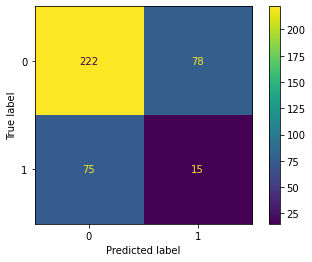

In [53]:
y_true = np.concatenate([y for x, y in test_features], axis=0)
x = np.concatenate([x for x, y in test_features], axis=0)
y_pred = lstm_model.predict(x)
y_pred = [1 * (x[0]>=0.5) for x in y_pred]

print(classification_report(y_true,y_pred))
ConfusionMatrixDisplay(confusion_matrix(y_true,y_pred)).plot()

Extract frames and save them as JPEG to create the image Dataset.

In [70]:
def save_frames(videos,path,label_of_batch):
    print("Writing images for "+label_of_batch+"...")
    for i,video in enumerate(videos):
        for j,frame in enumerate(video):
            cv.imwrite(path+f"/video{i+1}_frame{j+1}.jpg",cv.cvtColor(frame,cv.COLOR_RGB2BGR))


def create_image_dataset(split_data,n_labels,split_number,split_type):

    
    image_dtst_directory='../img_dataset/'
    n_of_videos_per_class=int(len(split_data)/n_labels)

    i=0
    for batch in range(n_labels):

        data=[]
        current_batch=split_data[i:i+n_of_videos_per_class]
        label_of_batch=current_batch[0][1]
    
        for name_and_label in current_batch:
            np_video=load_video('../hmdb51_org/'+name_and_label[1]+'/'+name_and_label[0],frames_per_video,frame_separation)
            data.append(np_video)
        
        path=image_dtst_directory+split_type+'/'+'split'+str(split_number)+'/'+label_of_batch
        if not os.path.exists(path):
            os.makedirs(path)
        save_frames(data,path,label_of_batch)
        i=i+n_of_videos_per_class

def create_binary_image_dataset(videos_with_labels,dataset_type):

    image_dtst_directory='../img_dataset/'
    fall_data=[]
    no_fall_data=[]
    for name_and_label in videos_with_labels:

        np_video=load_video('../hmdb51_org/'+name_and_label[1]+'/'+name_and_label[0],frames_per_video,frame_separation)

        if name_and_label[1] == "fall_floor":
            fall_data.append(np_video)
        else:
            no_fall_data.append(np_video)
    path_fall=image_dtst_directory+dataset_type+"/fall"

    if not os.path.exists(path_fall):
            os.makedirs(path_fall)

    path_no_fall=image_dtst_directory+dataset_type+"/no_fall"

    if not os.path.exists(path_no_fall):
            os.makedirs(path_no_fall)

    save_frames(fall_data,path_fall,"fall")
    save_frames(no_fall_data,path_no_fall,"no_fall")

#create_image_dataset(train_split1,1,'train')
#create_image_dataset(test_split1,1,'test')
# create_image_dataset(train_split1_adl,11,1,'train_adl')
# create_image_dataset(test_split1_adl,11,1,'test_adl')
create_binary_image_dataset(train_filenames_binary,'train_binary')
create_binary_image_dataset(test_filenames_binary,'test_binary')

Writing images for fall...
Writing images for no_fall...
Writing images for fall...
Writing images for no_fall...


In [72]:

train_img = tf.keras.utils.image_dataset_from_directory("../img_dataset/train_binary/",class_names=["no_fall","fall"],image_size=(240,240),shuffle=True)
test_img = tf.keras.utils.image_dataset_from_directory("../img_dataset/test_binary/",class_names=["no_fall","fall"],image_size=(240,240), shuffle=True)

Found 9100 files belonging to 2 classes.
Found 3900 files belonging to 2 classes.


CNN (Single Frame)

In [8]:
def new_cnn_model(n_labels,unfreeze_top_2=False):

    pretrained_model = tf.keras.applications.Xception(
        include_top=False,
        weights='imagenet',
        input_shape=(frame_size,frame_size,3),
        classifier_activation='softmax'
    )
    
    pretrained_model.trainable=False

    if(unfreeze_top_2):
        for layer in pretrained_model.layers[126:]:
            layer.trainable = True

    data_augmentation = tf.keras.Sequential(
        [tf.keras.layers.RandomFlip("horizontal"), tf.keras.layers.RandomRotation(0.1),],
        name = 'augmentation'
    )
    normalization = tf.keras.layers.Rescaling(scale=1/127.5, offset=-1, name='normalization')
    inputs = tf.keras.Input(shape=(frame_size,frame_size,3), name='input')

    preprocess = data_augmentation(inputs)
    preprocess = normalization(preprocess)

    x = pretrained_model(preprocess,training=False)
    x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
    #x = tf.keras.layers.Dropout(.5,name='dropout')(x)

    x = tf.keras.layers.Dense(2048, activation='relu', name='dense')(x)

    x = tf.keras.layers.Dropout(.5,name='dropout')(x)

    outputs = tf.keras.layers.Dense(n_labels,activation='softmax',name='dense_classification')(x)
    cnn_model = tf.keras.Model(inputs,outputs)

    cnn_model.compile(
        loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy',tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
    )

    return cnn_model

def new_binary_cnn_model(unfreeze_top_2=False):

    pretrained_model = tf.keras.applications.Xception(
        include_top=False,
        weights='imagenet',
        input_shape=(frame_size,frame_size,3),
        classifier_activation='softmax'
    )
    
    pretrained_model.trainable=False

    if(unfreeze_top_2):
        for layer in pretrained_model.layers[126:]:
            layer.trainable = True

    data_augmentation = tf.keras.Sequential(
        [tf.keras.layers.RandomFlip("horizontal"), tf.keras.layers.RandomRotation(0.1),],
        name = 'augmentation'
    )
    normalization = tf.keras.layers.Rescaling(scale=1/127.5, offset=-1, name='normalization')
    inputs = tf.keras.Input(shape=(frame_size,frame_size,3), name='input')

    preprocess = data_augmentation(inputs)
    preprocess = normalization(preprocess)

    x = pretrained_model(preprocess,training=False)
    x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
    #x = tf.keras.layers.Dropout(.5,name='dropout')(x)

    x = tf.keras.layers.Dense(2048, activation='relu', name='dense')(x)

    x = tf.keras.layers.Dropout(.5,name='dropout')(x)

    outputs = tf.keras.layers.Dense(1,activation='sigmoid',name='dense_sigmoid')(x)
    cnn_model = tf.keras.Model(inputs,outputs)

    cnn_model.compile(
        loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy',tf.keras.metrics.AUC()]
    )

    return cnn_model

In [9]:
cnn_model=new_cnn_model(51,unfreeze_top_2=True)
cnn_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 240, 240, 3)]     0         
                                                                 
 augmentation (Sequential)   (None, 240, 240, 3)       0         
                                                                 
 normalization (Rescaling)   (None, 240, 240, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling (Glo  (None, 2048)             0         
 balAveragePooling2D)                                            
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                           

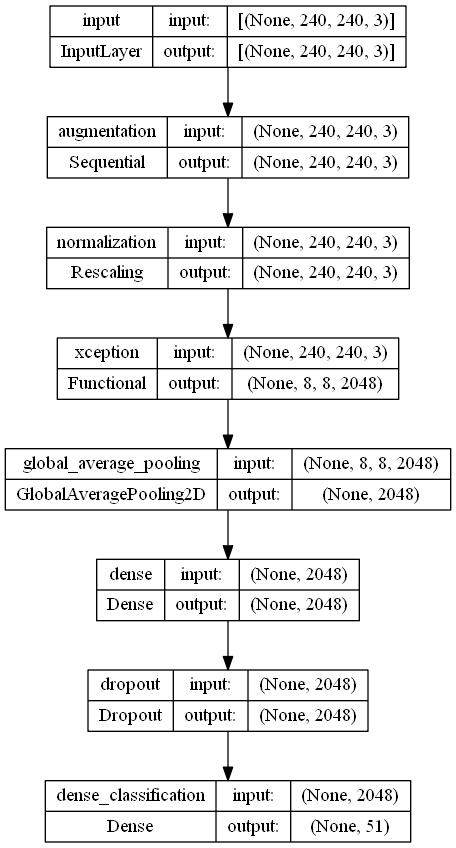

In [10]:
tf.keras.utils.plot_model(cnn_model, "cnn_modelo_tfg.png", show_shapes=True)

In [77]:
checkpoint_cb = checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "../checkpoint/binary_activity_CNNmodel_{epoch:02d}-{val_loss:.2f}.hdf5", save_best_only=True,
)

Epoch 1/100
285/285 [==============================] - 173s 584ms/step - loss: 0.3662 - binary_accuracy: 0.8438 - auc_1: 0.8667 - val_loss: 0.3824 - val_binary_accuracy: 0.8454 - val_auc_1: 0.8988
Epoch 2/100
285/285 [==============================] - 152s 535ms/step - loss: 0.2450 - binary_accuracy: 0.9003 - auc_1: 0.9432 - val_loss: 0.2670 - val_binary_accuracy: 0.8903 - val_auc_1: 0.9342
Epoch 3/100
285/285 [==============================] - 151s 532ms/step - loss: 0.1689 - binary_accuracy: 0.9360 - auc_1: 0.9735 - val_loss: 0.2676 - val_binary_accuracy: 0.8954 - val_auc_1: 0.9520
Epoch 4/100
285/285 [==============================] - 152s 535ms/step - loss: 0.1366 - binary_accuracy: 0.9476 - auc_1: 0.9827 - val_loss: 0.2867 - val_binary_accuracy: 0.8910 - val_auc_1: 0.9617
Epoch 5/100
285/285 [==============================] - 152s 533ms/step - loss: 0.0936 - binary_accuracy: 0.9648 - auc_1: 0.9917 - val_loss: 0.2130 - val_binary_accuracy: 0.9185 - val_auc_1: 0.9597
Epoch 6/100
285

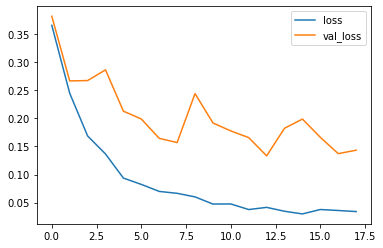

In [78]:
def run_cnn_experiment(train_data,test_data,n_labels):
    log_dir = "../logs/cnn_"+str(n_labels)+"/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

    history = cnn_model.fit(
        train_data,
        validation_data=test_data,
        epochs=100,
        
        callbacks=[checkpoint_cb,early_stopping_cb,tensorboard_cb],
    )

    history_df = pd.DataFrame(history.history)
    history_df.loc[:,['loss','val_loss']].plot()
    return history
history_cnn=run_cnn_experiment(train_img,test_img,2)

In [ ]:
# cnn_model.load_weights("../checkpoint/51activity_CNNmodel_01-2.55.hdf5")
# metrics = cnn_model.evaluate(test_img)
# metrics_used = cnn_model.metrics_names
# print(f"Test accuracy: {round(metrics[1]*100,2)}%")
# print(f"Top 5 accuracy: {round(metrics[2]*100,2)}%")

In [84]:

def get_graphics(experimentID,legend_loc='best',ylim=(0,1)):
    experiment = tb.data.experimental.ExperimentFromDev(experimentID)
    
    df = experiment.get_scalars()
    #print(df)
    df2 = df[df.tag.str.contains("iterations")==False]
    df2 = df2.pivot(index=["run","step"],columns=['tag'],values="value")
    df_val=df2[df2.index.get_level_values(0).str.contains("validation")]
    df_train=df2[df2.index.get_level_values(0).str.contains("train")]
    fig,ax=plt.subplots()

    df_val.loc[:,['epoch_accuracy','epoch_sparse_top_k_categorical_accuracy']].plot(use_index=False, ax=ax,xlabel='epochs',ylim=ylim)
    ax.legend(['Top1_accuracy','Top5_accuracy'],loc=legend_loc)

    ax=df_train.loc[:,['epoch_loss']].plot(use_index=False,xlabel='epoch')
    df_val.loc[:,['epoch_loss']].plot(ax=ax,use_index=False)
    ax.legend(['loss','val_loss'])

def get_binary_graphics(experimentID,legend_loc='best',ylim=(0,1)):
    experiment = tb.data.experimental.ExperimentFromDev(experimentID)
    
    df = experiment.get_scalars()
    #print(df)
    df2 = df[df.tag.str.contains("iterations")==False]
    df2 = df2.pivot(index=["run","step"],columns=['tag'],values="value")
    df_val=df2[df2.index.get_level_values(0).str.contains("validation")]
    df_train=df2[df2.index.get_level_values(0).str.contains("train")]
    fig,ax=plt.subplots()

    df_val.loc[:,['epoch_binary_accuracy','epoch_auc_1']].plot(use_index=False, ax=ax,xlabel='epochs',ylim=ylim,xlim=(0,18))
    ax.legend(['binary_accuracy','auc'],loc=legend_loc)

    ax=df_train.loc[:,['epoch_loss']].plot(use_index=False,xlabel='epoch',xlim=(0,18))
    df_val.loc[:,['epoch_loss']].plot(ax=ax,use_index=False)
    ax.legend(['loss','val_loss'])


Graphics for CNN 51 classes

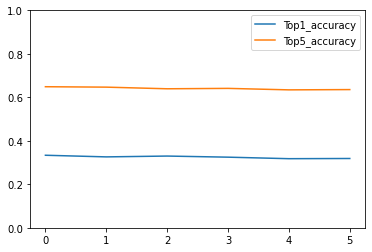

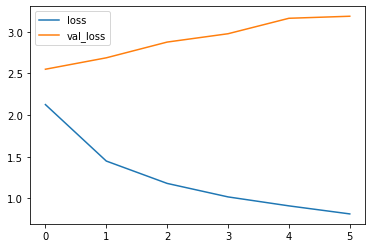

In [71]:
get_graphics('fnRkS1jzQeSnxy0C3jawsA')

Graphics for CNN 11 classes

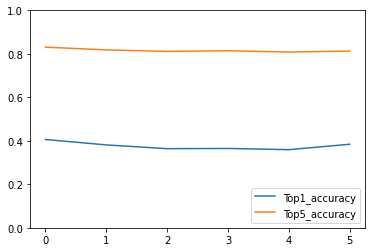

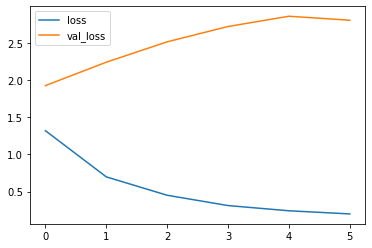

In [3]:
get_graphics("t9h4RejaSoCqAPn81szmqQ",'lower right')

Graphics for CNN binary

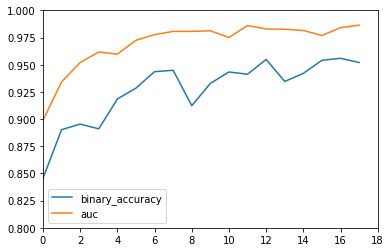

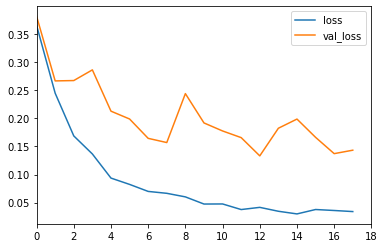

In [85]:
get_binary_graphics("kp1bNwnQR6SZyfoZimGJmA",ylim=(0.8,1))

Graphics for LSTM 51 classes

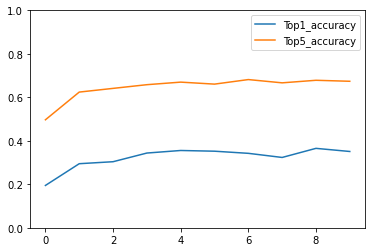

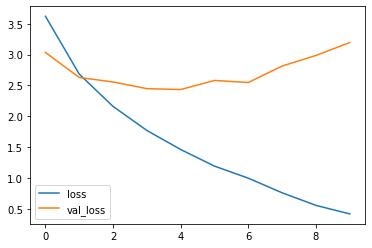

In [69]:
get_graphics("SBDpMaikRWOs0FX8l6ASdg")

Graphics for LSTM 11 classes

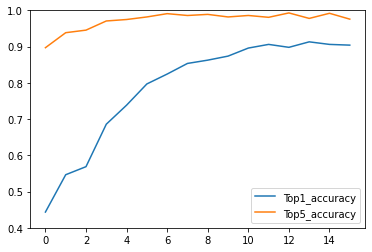

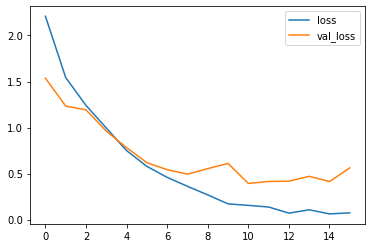

In [68]:
get_graphics("VHPmTj3qQzSMrjryxpOnBA",ylim=(0.4,1))

Graphics for LSTM binary

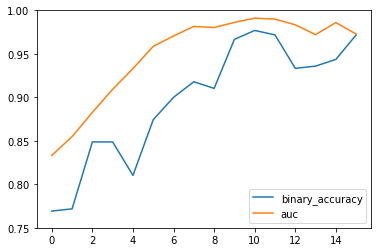

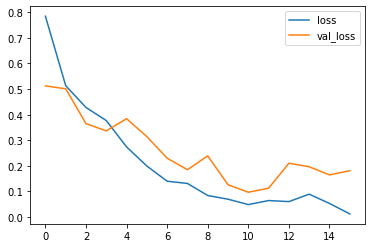

In [60]:
get_binary_graphics("mBb5NaTJQnOZhVTr4B9U8A",ylim=(0.75,1))